In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, fbeta_score
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
# Define ordinal encoding for birthweight and gestational age
bw = [
    '<500',
    '500-749',
    '750-999',
    '1000-1249',
    '1250-1499',
    '1500-1749',
     '1750-1999',
    '2000-2499',
    '>2500'
]
ga = [
    '<=24',
    '25-26',
    '27-28',
    '29-30',
    '31-32',
    # '33-34',
    # '35-36',
    # '>36'
]

In [3]:
# Define CRIB-II score for sex, ga, bw
crib2 = {
    'M': {
        '<=24': {
            '<500': 14,
            '500-749': 13,
            '750-999': 11.5,
            '1000-1249': 11,
            '1250-1499': 11, #np.nan,
            '1500-1749': 11, #np.nan,
             '1750-1999': 11, #np.nan,
            '2000-2499': 11, #np.nan,
            '>2500': 11, #np.nan
        },
        '25-26': {
            '<500': 11.5,
            '500-749': 10.5,
            '750-999': 9,
            '1000-1249': 8.5,
            '1250-1499': 8,
            '1500-1749': 8, #np.nan,
             '1750-1999': 8, #np.nan,
            '2000-2499': 8, #np.nan,
            '>2500': 8, #np.nan,
        },
        '27-28': {
            '<500': 10,
            '500-749': 8.5,
            '750-999': 7,
            '1000-1249': 6.5,
            '1250-1499': 5.5,
            '1500-1749': 5.5,
             '1750-1999': 5.5, #np.nan,
            '2000-2499': 5.5, #np.nan,
            '>2500': 5.5, #np.nan
        },
        '29-30': {
            '<500': 8, #np.nan,
            '500-749': 8,
            '750-999': 6,
            '1000-1249': 4.5,
            '1250-1499': 3,
            '1500-1749': 2.5,
             '1750-1999': 2,
            '2000-2499': 2.5,
            '>2500': 2.5, #np.nan 
        },
        '31-32': {
            '<500': 8, #np.nan,
            '500-749': 8,
            '750-999': 6,
            '1000-1249': 3,
            '1250-1499': 1.5,
            '1500-1749': 0.5,
             '1750-1999': 0,
            '2000-2499': 0,
            '>2500': 0
        }
    },
    'F': {
        '<=24': {
            '<500': 13,
            '500-749': 12,
            '750-999': 10.5,
            '1000-1249': 10.5,
            '1250-1499': 10.5, #np.nan,
            '1500-1749': 10.5, #np.nan,
             '1750-1999': 10.5, #np.nan,
            '2000-2499': 10.5, #np.nan,
            '>2500': 10.5, #np.nan
        },
        '25-26': {
            '<500': 11,
            '500-749': 9.5,
            '750-999': 8.5,
            '1000-1249': 7.5,
            '1250-1499': 7,
            '1500-1749': 7, #np.nan,
             '1750-1999': 7, #np.nan,
            '2000-2499': 7, #np.nan,
            '>2500': 7, #np.nan
        },
        '27-28': {
            '<500': 10,
            '500-749': 8,
            '750-999': 6.5,
            '1000-1249': 5.5,
            '1250-1499': 4.5,
            '1500-1749': 5,
             '1750-1999': 5, #np.nan,
            '2000-2499': 5, #np.nan,
            '>2500': 5, #np.nan
        },
        '29-30': {
            '<500': 7,#np.nan,
            '500-749': 7,
            '750-999': 5,
            '1000-1249': 3.5,
            '1250-1499': 2.5,
            '1500-1749': 2,
             '1750-1999': 2,
            '2000-2499': 1,
            '>2500': 1, #np.nan
        },
        '31-32': {
            '<500': 7, #np.nan,
            '500-749': 7,
            '750-999': 5,
            '1000-1249': 3,
            '1250-1499': 1,
            '1500-1749': 0,
             '1750-1999': 0,
            '2000-2499': 0,
            '>2500': 0
        }
    }
}

In [4]:
df = pd.read_csv('cohorts/cohort_t12.csv')

In [5]:
df = df[df['ga'].isin(ga)]

In [6]:
df['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    975
1     56
Name: count, dtype: int64

In [7]:
select_labs = [
    'Base Excess',
    # 'pO2',
    # 'pCO2',
    # 'pH',
    # 'Hematocrit',
    # 'White Blood Cells',
    # 'Platelet Count',
]
features = [
    'ga',
    'bw',
    'gender',
    # 'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    'Base Excess_count',
    # 'pO2_count',
    # 'pCO2_count',
    # 'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]
features_to_scale = [
    'gender_ga_bw',
    # 'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    'Base Excess_count',
    # 'pO2_count',
    # 'pCO2_count',
    # 'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]

In [8]:
''' 
data_split: returns features (X) and labels (y) for three non-overlapping subsets of the given data frame
'''
def data_split(df, features, train_split, holdout_anchor_year_group):
    # Select specified features
    df = df[['subject_id', 'hospital_expire_flag', 'anchor_year_group'] + features]
    
    # Split dataset into training and testing subsets by time (de-identified temporal proxy is anchor_year_group, holdout on future samples)
    test_df = df[df['anchor_year_group'] == holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    train_df = df[df['anchor_year_group'] != holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    
    # Split data frames into features and labels
    X = train_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    X_test = test_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    y = train_df['hospital_expire_flag']
    y_test = test_df['hospital_expire_flag']

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1-train_split, random_state=42, stratify=y)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df, features, train_split=0.8, holdout_anchor_year_group='2017 - 2019')

In [9]:
def impute_ga_bw(X):
    X[['bw', 'ga']] = X[['bw', 'ga']].replace('UNK', np.nan)
    X['bw_imp'] = X['bw'].fillna(X.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X['ga_imp'] = X['ga'].fillna(X.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X = X.drop(['bw', 'ga'], axis=1)
    return X

In [10]:
def encode_ga_bw(X, bw, ga):
    bw_encoding = {bucket: idx for idx, bucket in enumerate(bw)}
    ga_encoding = {bucket: idx for idx, bucket in enumerate(ga)}
    X['bw_enc'] = X['bw_imp'].map(bw_encoding)
    X['ga_enc'] = X['ga_imp'].map(ga_encoding)
    X = X.drop(['bw_imp', 'ga_imp'], axis=1)
    return X

In [11]:
def encode_gender(X):
    X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
    return X

In [12]:
def crib2_gender_ga_bw(x):
    return crib2[x['gender']][x['ga_imp']][x['bw_imp']]

def encode_crib2_gender_ga_bw(X):
    X['gender_ga_bw'] = X.apply(crib2_gender_ga_bw, axis=1)
    X = X.drop(['gender', 'ga_imp', 'bw_imp'], axis=1)
    return X

In [13]:
def crib2_base_excess(x):
    if x < -26: return 7
    elif x <= -23: return 6
    elif x <= -18: return 5
    elif x <= -13: return 4
    elif x <= -8: return 3
    elif x <= -3: return 2
    elif x <= 2: return 1
    elif x >= 3: return 0

def encode_crib2_base_excess(X):
    X['Base Excess_valuenum'] = X['Base Excess_valuenum'].apply(crib2_base_excess)
    return X

In [14]:
def impute_lab_values(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_valuenum'
        if lab_col in X: X[lab_col] = X[lab_col].fillna(X[lab_col].mean())
    return X
    
def impute_lab_flags(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_flag'
        if lab_col in X: X[lab_col] = X[lab_col].fillna('normal')
    return X

In [15]:
def fit_scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

def scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.transform(X[features_to_scale])

In [16]:
def smote(X, y, sampling_strategy=0.3):
    smote = SMOTE(sampling_strategy=sampling_strategy) 
    X_upsampled, y_upsampled = smote.fit_resample(X, y)
    return X_upsampled, y_upsampled

In [17]:
def preprocess_pipeline(X, scaler, train=True):
    X = impute_ga_bw(X)
    # X = encode_ga_bw(X, bw, ga)
    # X = encode_gender(X)
    X = encode_crib2_gender_ga_bw(X)
    X = impute_lab_values(X, select_labs)
    # X = encode_crib2_base_excess(X)
    if train: fit_scale(X, scaler, features_to_scale)
    else: scale(X, scaler, features_to_scale)
    return X

In [18]:
scaler = StandardScaler()
X_train = preprocess_pipeline(X_train, scaler, train=True)
X_val = preprocess_pipeline(X_val, scaler, train=False)
X_test = preprocess_pipeline(X_test, scaler, train=False)

In [19]:
# X_train, y_train = smote(X_train, y_train, sampling_strategy=0.3)

In [20]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

hospital_expire_flag
0    610
1     34
Name: count, dtype: int64
hospital_expire_flag
0    154
1      8
Name: count, dtype: int64
hospital_expire_flag
0    211
1     14
Name: count, dtype: int64


In [21]:
def train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, sample_weight=None):
    if sample_weight is None: model.fit(X_train, y_train)
    else: model.fit(X_train, y_train, sample_weight=sample_weight)
    eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

def eval_metrics(model, X, y, split=None):
    if split: print(f"{split}:\n")
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    print("Accuracy:", accuracy_score(y, y_pred))
    print("AUROC:", roc_auc_score(y, y_prob))
    print("AUCPR:", average_precision_score(y, y_prob))
    print("F2:", fbeta_score(y, y_pred, beta=2, average='binary'))
    print("\nClassification Report:\n", classification_report(y, y_pred))

def eval(model, X_train, y_train, X_val, y_val, X_test, y_test):
    eval_metrics(model, X_train, y_train, split="Training")
    eval_metrics(model, X_val, y_val, split="Validation")
    eval_metrics(model, X_test, y_test, split="Testing")

In [22]:
model = LogisticRegression(penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

Training:

Accuracy: 0.9518633540372671
AUROC: 0.9158630665380907
AUCPR: 0.4432066073739145
F2: 0.17482517482517482

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       610
           1       0.71      0.15      0.24        34

    accuracy                           0.95       644
   macro avg       0.83      0.57      0.61       644
weighted avg       0.94      0.95      0.94       644

Validation:

Accuracy: 0.9753086419753086
AUROC: 0.8689123376623377
AUCPR: 0.6051681623413372
F2: 0.5555555555555556

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       154
           1       1.00      0.50      0.67         8

    accuracy                           0.98       162
   macro avg       0.99      0.75      0.83       162
weighted avg       0.98      0.98      0.97       162

Testing:

Accuracy: 0.9422222222222222
AUROC: 0.919092755585646

In [23]:
model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

Training:

Accuracy: 0.8322981366459627
AUROC: 0.9167309546769528
AUCPR: 0.44582975824983273
F2: 0.5410447761194029

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       610
           1       0.22      0.85      0.35        34

    accuracy                           0.83       644
   macro avg       0.60      0.84      0.63       644
weighted avg       0.95      0.83      0.87       644

Validation:

Accuracy: 0.8271604938271605
AUROC: 0.869724025974026
AUCPR: 0.6069956477214542
F2: 0.5303030303030303

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       154
           1       0.21      0.88      0.33         8

    accuracy                           0.83       162
   macro avg       0.60      0.85      0.62       162
weighted avg       0.95      0.83      0.87       162

Testing:

Accuracy: 0.8755555555555555
AUROC: 0.9238320920785376

In [24]:
# Logistic regression feature importance
feature_names = X_train.columns
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

             Feature  Coefficient  Absolute_Coefficient
1       gender_ga_bw     1.465935              1.465935
0  Base Excess_count     0.846095              0.846095


In [25]:
model = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

Training:

Accuracy: 0.8322981366459627
AUROC: 0.9167309546769528
AUCPR: 0.44582975824983273
F2: 0.5410447761194029

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       610
           1       0.22      0.85      0.35        34

    accuracy                           0.83       644
   macro avg       0.60      0.84      0.63       644
weighted avg       0.95      0.83      0.87       644

Validation:

Accuracy: 0.8271604938271605
AUROC: 0.869724025974026
AUCPR: 0.6069956477214542
F2: 0.5303030303030303

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       154
           1       0.21      0.88      0.33         8

    accuracy                           0.83       162
   macro avg       0.60      0.85      0.62       162
weighted avg       0.95      0.83      0.87       162

Testing:

Accuracy: 0.8755555555555555
AUROC: 0.9238320920785376

In [26]:
grid_search_scoring = 'recall'

In [27]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 5],
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=grid_search_scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

model = grid_search.best_estimator_

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.8238095238095238


In [28]:
eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

Training:

Accuracy: 0.812111801242236
AUROC: 0.920443587270974
AUCPR: 0.41787753025026825
F2: 0.5300353356890459

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89       610
           1       0.20      0.88      0.33        34

    accuracy                           0.81       644
   macro avg       0.60      0.85      0.61       644
weighted avg       0.95      0.81      0.86       644

Validation:

Accuracy: 0.8209876543209876
AUROC: 0.8567370129870129
AUCPR: 0.6045524691358024
F2: 0.5223880597014925

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       154
           1       0.20      0.88      0.33         8

    accuracy                           0.82       162
   macro avg       0.60      0.85      0.61       162
weighted avg       0.95      0.82      0.87       162

Testing:

Accuracy: 0.8355555555555556
AUROC: 0.9136763710223426


In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

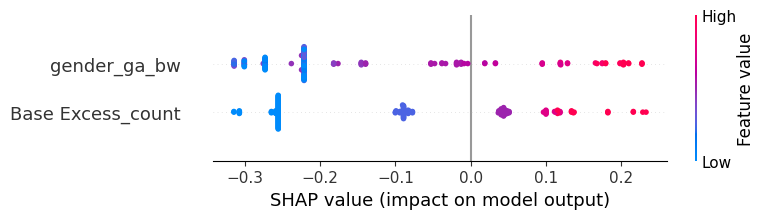

In [30]:
shap_values_dead = shap_values[..., 1]
shap.summary_plot(shap_values_dead, features=X_val, feature_names=X_val.columns)

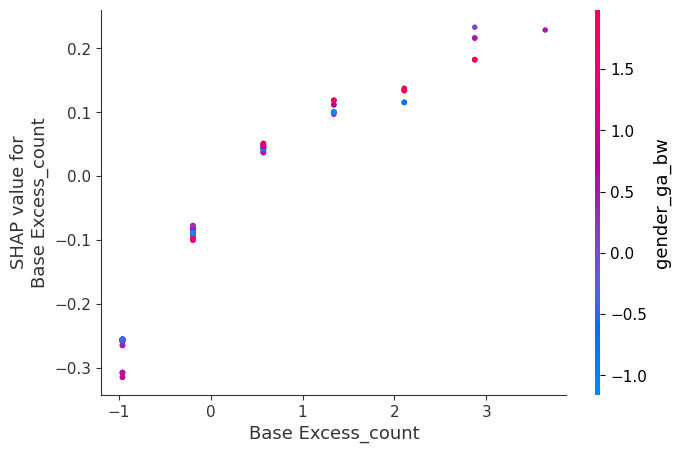

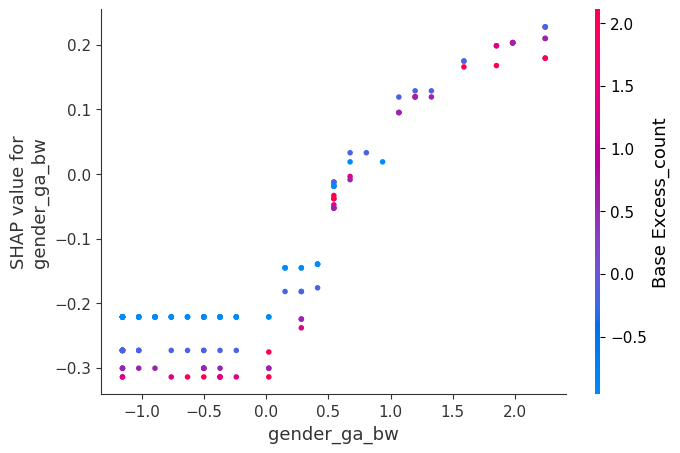

In [31]:
for feature in X_val.columns: shap.dependence_plot(feature, shap_values[..., 1], X_val)

             Feature  Gini Importance
1       gender_ga_bw         0.537103
0  Base Excess_count         0.462897


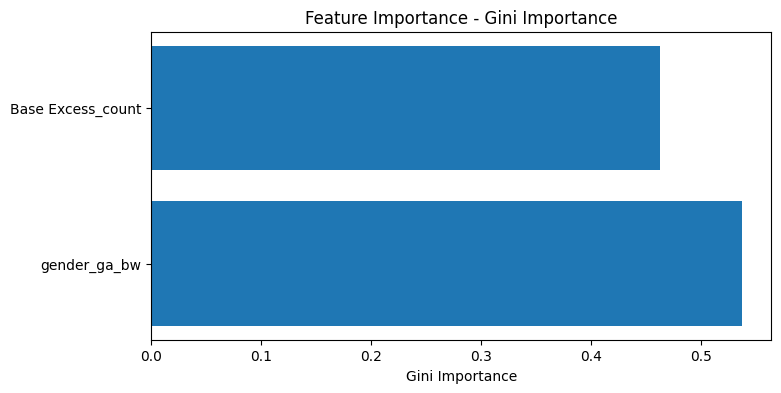

In [32]:
# Random forest feature importance
feature_names = X_train.columns
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

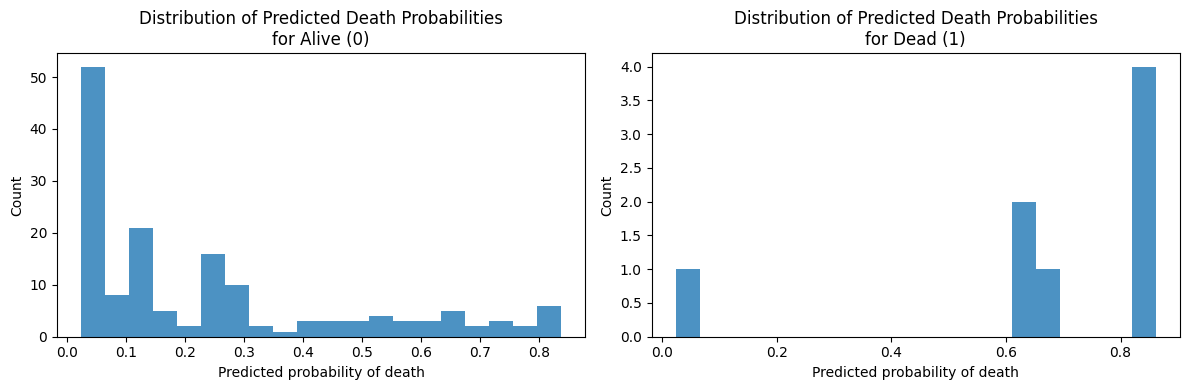

In [33]:
y_prob = model.predict_proba(X_val)[:,1]
prob_alive = y_prob[np.array(y_val) == 0]
prob_dead  = y_prob[np.array(y_val) == 1]

plt.figure(figsize=(12, 4))

# --- Plot 1: Alive ---
plt.subplot(1, 2, 1)
plt.hist(prob_alive, bins=20, alpha=0.8)
plt.title("Distribution of Predicted Death Probabilities\nfor Alive (0)")
plt.xlabel("Predicted probability of death")
plt.ylabel("Count")

# --- Plot 2: Dead ---
plt.subplot(1, 2, 2)
plt.hist(prob_dead, bins=20, alpha=0.8)
plt.title("Distribution of Predicted Death Probabilities\nfor Dead (1)")
plt.xlabel("Predicted probability of death")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# TODO: merge the plots to make a stacked plot and show the threshold (0.5)

In [34]:
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(brf, param_grid=param_grid, scoring=grid_search_scoring, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5}
Best score: 0.9380952380952381


In [35]:
eval(model, X_train, y_train, X_val, y_val, X_test, y_test)

Training:

Accuracy: 0.7841614906832298
AUROC: 0.9163693346190935
AUCPR: 0.34735976963295073
F2: 0.5245901639344263

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87       610
           1       0.19      0.94      0.32        34

    accuracy                           0.78       644
   macro avg       0.59      0.86      0.59       644
weighted avg       0.95      0.78      0.84       644

Validation:

Accuracy: 0.7839506172839507
AUROC: 0.8336038961038961
AUCPR: 0.4050538561503474
F2: 0.4794520547945205

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87       154
           1       0.17      0.88      0.29         8

    accuracy                           0.78       162
   macro avg       0.58      0.83      0.58       162
weighted avg       0.95      0.78      0.84       162

Testing:

Accuracy: 0.7866666666666666
AUROC: 0.912491536899119